##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.

本教程演示了從存儲在磁盤上的純文本文件開始的文本分類。 您將訓練二元分類器以對 IMDB 數據集執行情感分析。 在筆記本的末尾，有一個練習供您嘗試，您將在其中訓練一個多類分類器來預測 Stack Overflow 上編程問題的標籤。


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [4]:
print(tf.__version__)

2.11.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

## 情緒分析

此筆記本訓練情感分析模型，根據評論文本將電影評論分類為*正面*或*負面*。 這是*二元*（或二分類）分類的示例，這是一種重要且廣泛應用的機器學習問題。

您將使用 [大型電影評論數據集](https://ai.stanford.edu/~amaas/data/sentiment/)，其中包含來自 [Internet Movie Database](https:// www.imdb.com/）。 這些分為 25,000 條訓練評論和 25,000 條測試評論。 訓練集和測試集是*平衡*的，這意味著它們包含相同數量的正面和負面評論。

### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

讓我們下載並提取數據集，然後探索目錄結構。

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 110s 1us/step


In [6]:
os.listdir(dataset_dir)

['train', 'README', 'test', 'imdb.vocab', 'imdbEr.txt']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_pos.txt',
 'neg',
 'unsup',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat',
 'urls_neg.txt']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

`aclImdb/train/pos` 和 `aclImdb/train/neg` 目錄包含許多文本文件，每個文件都是一篇電影評論。 讓我們來看看其中的一個。

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

### 加載數據集

接下來，您將從磁盤加載數據並將其準備為適合訓練的格式。 為此，您將使用有用的 [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) 實用程序，它需要如下目錄結構。

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

要準備用於二元分類的數據集，您需要在磁盤上創建兩個文件夾，分別對應“class_a”和“class_b”。 這些將是正面和負面的電影評論，可以在 `aclImdb/train/pos` 和 `aclImdb/train/neg` 中找到。 由於 IMDB 數據集包含其他文件夾，您將在使用此實用程序之前刪除它們。

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

接下來，您將使用“text_dataset_from_directory”實用程序創建一個帶標籤的“tf.data.Dataset”。 [tf.data](https://www.tensorflow.org/guide/data) 是一組功能強大的數據處理工具。

運行機器學習實驗時，最佳做法是將數據集分成三部分：[訓練](https://developers.google.com/machine-learning/glossary#training_set)、[驗證](https:/ /developers.google.com/machine-learning/glossary#validation_set）和[測試](https://developers.google.com/machine-learning/glossary#test-set)。

IMDB 數據集已經分為訓練和測試，但缺少驗證集。 讓我們使用下面的“validation_split”參數，使用訓練數據的 80:20 分割來創建驗證集。

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

如上所示，訓練文件夾中有 25,000 個示例，您將使用其中的 80%（或 20,000 個）進行訓練。 正如您稍後將看到的，您可以通過將數據集直接傳遞給“model.fit”來訓練模型。 如果您是 `tf.data` 的新手，您還可以迭代數據集並打印出幾個示例，如下所示。

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.

請注意，評論包含原始文本（帶有標點符號和偶爾的 HTML 標記，如“<br/>”）。 您將在下一節中展示如何處理這些。

標籤為 0 或 1。要查看其中哪些對應於正面和負面電影評論，您可以檢查數據集上的“class_names”屬性。

In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

接下來，您將創建驗證和測試數據集。 您將使用訓練集中剩餘的 5,000 條評論進行驗證。

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

注意：使用 `validation_split` 和 `subset` 參數時，請確保指定隨機種子或傳遞 `shuffle=False`，以便驗證和訓練拆分不會重疊。

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

### 準備訓練數據集

接下來，您將使用有用的“tf.keras.layers.TextVectorization”層對數據進行標準化、標記化和矢量化。

標準化是指對文本進行預處理，通常是刪除標點符號或 HTML 元素以簡化數據集。 標記化是指將字符串拆分為標記（例如，通過拆分空格將句子拆分為單個單詞）。 矢量化是指將標記轉換為數字，以便將它們輸入神經網絡。 所有這些任務都可以通過這一層來完成。

正如您在上面看到的，評論包含各種 HTML 標記，例如 `<br />`。 這些標籤不會被 TextVectorization 層中的默認標準化程序刪除（默認情況下會將文本轉換為小寫並去除標點符號，但不會去除 HTML）。 您將編寫一個自定義標準化函數來刪除 HTML。

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

注意：為防止[訓練-測試偏差](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)（也稱為訓練-服務偏差），重要的是 在訓練和測試時對數據進行相同的預處理。 為了促進這一點，可以將 TextVectorization 層直接包含在模型中，如本教程後面所示。

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

接下來，您將創建一個 TextVectorization 層。 您將使用該層對我們的數據進行標準化、標記化和矢量化。 您將 `output_mode` 設置為 `int` 以為每個標記創建唯一的整數索引。

請注意，您使用的是默認拆分函數，以及您在上面定義的自定義標準化函數。 您還將為模型定義一些常量，例如顯式最大“sequence_length”，這將導致層將序列填充或截斷為恰好“sequence_length”值。

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

接下來，您將調用“adapt”來使預處理層的狀態適應數據集。 這將導致模型構建一個字符串索引到整數。

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

注意：重要的是在調用 adapt 時只使用你的訓練數據（使用測試集會洩露信息）。

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Let's create a function to see the result of using this layer to preprocess some data.

讓我們創建一個函數來查看使用該層預處理一些數據的結果。

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

正如您在上面看到的，每個標記都已替換為一個整數。 您可以通過在圖層上調用 .get_vocabulary() 來查找每個整數對應的標記（字符串）。

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

您幾乎已準備好訓練您的模型。 作為最後的預處理步驟，您會將之前創建的 TextVectorization 層應用於訓練、驗證和測試數據集。

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

### 配置數據集以提高性能

這是加載數據時應使用的兩種重要方法，以確保 I/O 不會阻塞。

.cache() 將數據從磁盤加載後保存在內存中。 這將確保數據集在訓練模型時不會成為瓶頸。 如果您的數據集太大而無法放入內存，您還可以使用此方法創建一個高性能的磁盤緩存，這比許多小文件的讀取效率更高。

`.prefetch()` 在訓練時與數據預處理和模型執行重疊。

您可以在[數據性能指南](https://www.tensorflow.org/guide/data_performance)中詳細了解這兩種方法以及如何將數據緩存到磁盤。

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

是時候創建你的神經網絡了：

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

這些層按順序堆疊以構建分類器：

1. 第一層是“嵌入”層。 該層採用整數編碼的評論並為每個單詞索引查找嵌入向量。 這些向量是在模型訓練時學習的。 向量向輸出數組添加一個維度。 結果維度是：`(batch, sequence, embedding)`。 要了解有關嵌入的更多信息，請查看 [Word 嵌入](https://www.tensorflow.org/text/guide/word_embeddings) 教程。
2. 接下來，“GlobalAveragePooling1D”層通過對序列維度進行平均，為每個示例返回一個固定長度的輸出向量。 這允許模型以最簡單的方式處理可變長度的輸入。
3. 這個固定長度的輸出向量通過具有 16 個隱藏單元的全連接（“密集”）層進行傳輸。
4. 最後一層與單個輸出節點密集連接。

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

### 損失函數和優化器

一個模型需要一個損失函數和一個優化器來訓練。 由於這是一個二元分類問題，並且模型輸出概率（具有 sigmoid 激活的單單元層），因此您將使用 `losses.BinaryCrossentropy` 損失函數。

現在，配置模型以使用優化器和損失函數：

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

您將通過將“dataset”對像傳遞給 fit 方法來訓練模型。

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6657 - binary_accuracy: 0.6926 - val_loss: 0.6171 - val_binary_accuracy: 0.7712
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5505 - binary_accuracy: 0.7998 - val_loss: 0.4997 - val_binary_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4469 - binary_accuracy: 0.8447 - val_loss: 0.4212 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3792 - binary_accuracy: 0.8641 - val_loss: 0.3744 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3368 - binary_accuracy: 0.8779 - val_loss: 0.3455 - val_binary_accuracy: 0.8664
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3057 - binary_accuracy: 0.8888 - val_loss: 0.3265 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 1s 2ms/ste

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

讓我們看看模型的表現如何。 將返回兩個值。 損失（代表我們的錯誤的數字，值越低越好）和準確性。

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 775us/step - loss: 0.3108 - binary_accuracy: 0.8730
Loss:  0.3108227252960205
Accuracy:  0.8730000257492065


This fairly naive approach achieves an accuracy of about 86%.

這種相當天真的方法達到了大約 86% 的準確率。

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

### 創建精度和損失隨時間變化的圖

`model.fit()` 返回一個 `History` 對象，其中包含一個字典，其中包含訓練期間發生的所有事情：

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

有四個條目：一個用於訓練和驗證期間的每個監控指標。 您可以使用這些來繪製訓練和驗證損失以進行比較，以及訓練和驗證的準確性：

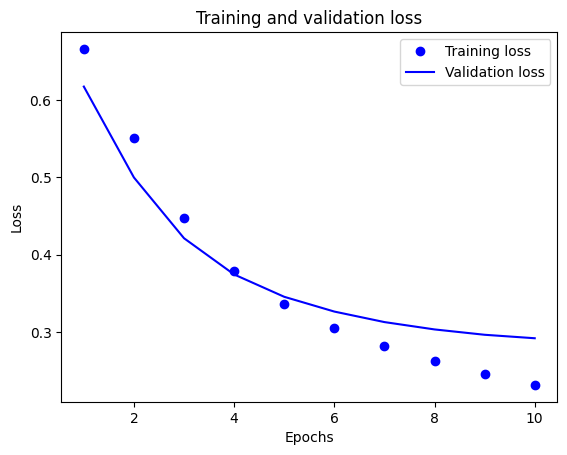

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

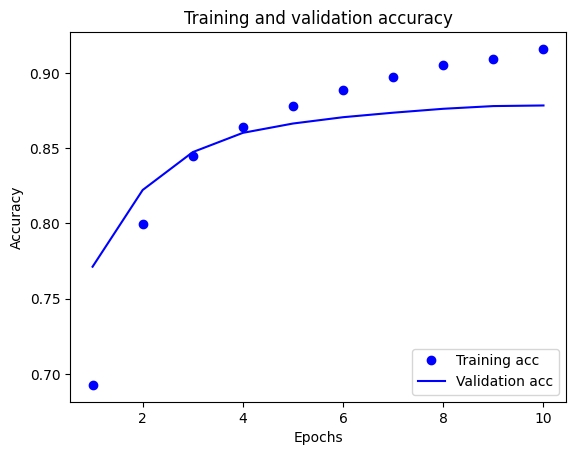

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

在此圖中，點代表訓練損失和準確性，實線代表驗證損失和準確性。

請注意，每個時期的訓練損失*減少*，每個時期的訓練準確性*增加*。 這在使用梯度下降優化時是意料之中的——它應該在每次迭代中最小化所需的數量。

驗證損失和準確性並非如此——它們似乎在訓練準確性之前達到峰值。 這是過度擬合的一個例子：模型在訓練數據上的表現比在它以前從未見過的數據上的表現要好。 在這一點之後，模型會過度優化並學習“特定於”訓練數據的表示，這些表示不會“泛化”到測試數據。

對於這種特殊情況，您可以通過在驗證準確性不再增加時簡單地停止訓練來防止過度擬合。 一種方法是使用“tf.keras.callbacks.EarlyStopping”回調。

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

## 導出模型

在上面的代碼中，您在將文本輸入到模型之前將 TextVectorization 層應用於數據集。 如果你想讓你的模型能夠處理原始字符串（例如，為了簡化它的部署），你可以在你的模型中包含 TextVectorization 層。 為此，您可以使用剛剛訓練的權重創建一個新模型。

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 1s 1ms/step - loss: 0.3108 - accuracy: 0.8730
0.8730000257492065


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

### 對新數據的推斷

要獲得對新示例的預測，您只需調用 model.predict() 即可。

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 67ms/step


array([[0.60919577],
       [0.43033266],
       [0.34812528]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

在模型中包含文本預處理邏輯使您能夠導出用於生產的模型，從而簡化部署，並減少[訓練/測試偏差](https://developers.google.com/machine-learning/guides/rules- of-ml#training-serving_skew）。

選擇在何處應用 TextVectorization 層時，需要牢記性能差異。 在您的模型之外使用它可以讓您在 GPU 上訓練時對數據進行異步 CPU 處理和緩衝。 因此，如果您在 GPU 上訓練模型，您可能希望在開發模型時使用此選項以獲得最佳性能，然後在準備好部署時切換到在模型中包含 TextVectorization 層 .

訪問此[教程](https://www.tensorflow.org/tutorials/keras/save_and_load) 以了解有關保存模型的更多信息。

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

## 練習：Stack Overflow 問題的多類分類

本教程展示瞭如何在 IMDB 數據集上從頭開始訓練二元分類器。 作為練習，您可以修改此筆記本以訓練多類分類器來預測 [Stack Overflow](http://stackoverflow.com/) 上編程問題的標籤。

一個 [數據集](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) 已經準備好供您使用，其中包含數千個編程問題的正文（例如，“How 我可以在 Python 中按值對字典進行排序嗎？”）發佈到 Stack Overflow。 其中每一個都標有一個標籤（Python、CSharp、JavaScript 或 Java）。 您的任務是將問題作為輸入，並預測適當的標籤，在本例中為 Python。

您將使用的數據集包含從 [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) 上更大的公共 Stack Overflow 數據集中提取的數千個問題，其中 包含超過 1700 萬個帖子。

下載數據集後，您會發現它與您之前使用的 IMDB 數據集具有相似的目錄結構：

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier. 

注意：為了增加分類問題的難度，編程問題中出現的單詞 Python、CSharp、JavaScript 或 Java 已替換為單詞 *blank*（因為許多問題包含它們所涉及的語言）。

要完成此練習，您應該通過進行以下修改來修改此筆記本以使用 Stack Overflow 數據集：

1. 在筆記本的頂部，使用代碼更新下載 IMDB 數據集的代碼以下載 [Stack Overflow 數據集](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar。 gz) 已經準備好了。 由於 Stack Overflow 數據集具有相似的目錄結構，因此您無需進行太多修改。

1. 將模型的最後一層修改為“Dense(4)”，因為現在有四個輸出類。

1.編譯模型時，將loss改為`tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`。 這是用於多類分類問題的正確損失函數，當每個類的標籤都是整數時（在這種情況下，它們可以是 0、*1*、*2* 或 *3*）。 此外，將指標更改為“metrics=['accuracy']”，因為這是一個多類分類問題（“tf.metrics.BinaryAccuracy”僅用於二元分類器）。

1. 繪製精度隨時間變化時，將 `binary_accuracy` 和 `val_binary_accuracy` 分別更改為 `accuracy` 和 `val_accuracy`。

1. 完成這些更改後，您將能夠訓練多類分類器。

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.

## 學習更多

本教程從頭開始介紹文本分類。 要了解有關一般文本分類工作流程的更多信息，請查看 Google Developers 的[文本分類指南](https://developers.google.com/machine-learning/guides/text-classification/)。
